In [21]:
import pandas as pd
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [2]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HTW1KOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HTW1KOR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('Data.csv', encoding='unicode_escape') 

In [4]:
print(df['Label'].value_counts())

Label
1                                                                                                                                                                                                                                                                                                     2166
0                                                                                                                                                                                                                                                                                                     1935
b'FBI arrests 10 Russian Spies in U.S.'                                                                                                                                                                                                                                                                  1
b'PHILIPPINES Key witness in the Maguindanao massacre case killed'                               

In [5]:
df.isna().sum()

Date       0
Label     48
Top1      52
Top2      60
Top3      70
Top4      93
Top5     104
Top6     111
Top7     118
Top8     127
Top9     135
Top10    144
Top11    156
Top12    162
Top13    171
Top14    179
Top15    187
Top16    191
Top17    198
Top18    208
Top19    213
Top20    222
Top21    232
Top22    246
Top23    252
Top24    256
Top25    258
dtype: int64

In [6]:
# Drop rows with NaN values in relevant columns
df.dropna(subset=['Label'] + [f'Top{i}' for i in range(1, 26)], inplace=True)

# Optionally, fill NaN values in the headline columns with empty strings (if you prefer not to drop rows)
for col in [f'Top{i}' for i in range(1, 26)]:
    df[col] = df[col].fillna('')

# After handling NaN, reset the index
df.reset_index(drop=True, inplace=True)

In [7]:
df.isna().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    0
Top24    0
Top25    0
dtype: int64

In [9]:
df.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite


In [12]:
# Combine all headline columns (Top1 to Top25) into a single text column
df['Combined_Text'] = df.loc[:, 'Top1':'Top25'].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [13]:
# Clean the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [14]:
print(stop_words)
print(lemmatizer)

{'theirs', 'm', 'themselves', 'yours', 'against', 'hadn', "couldn't", 'were', 'about', 'few', "shan't", 'through', 'under', 'and', 'can', 'he', 'any', 'or', 'shan', 'all', 'are', 'both', 'you', 'when', 'own', 'was', 'than', 'on', "don't", 'before', 'while', 'ourselves', 'most', 'such', 'doing', 'having', 'until', 'up', 'how', 'some', 't', 'those', 'if', 'do', 'during', 'aren', 'here', 'wasn', 'their', 'needn', 'below', 'it', "it's", "that'll", 'this', 'more', 'will', 'from', "hadn't", 'whom', "isn't", 'don', 'because', 'not', 'our', 'been', 'be', 'only', "mustn't", 'too', "wouldn't", "wasn't", "you've", 'its', 'does', 'ma', 'mustn', 'her', 'am', 'what', 'just', 're', 'itself', 'ours', 'your', 'is', 'y', "aren't", "shouldn't", 'no', 'mightn', 'did', 'same', "should've", 'ain', 'didn', 'won', 'after', "mightn't", 'd', "you'd", 'll', "you'll", 'further', 'now', 'to', 'who', "doesn't", 'doesn', 'once', 'down', "haven't", 'into', 'each', 'nor', 'himself', 'again', 'o', "didn't", 'weren', 'y

In [15]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

In [16]:
df['Cleaned_Text'] = df['Combined_Text'].apply(preprocess_text)

In [17]:
df["Cleaned_Text"]

0       hindrance operation extract leaked report scor...
1       scorecard best lake scene leader german sleaze...
2       coventry caught counter flo uniteds rival road...
3       pilgrim know progress thatcher facing ban mcil...
4       hitch horlocks beckham united survive breast c...
                              ...                        
3999    barclays rb share suspended trading tanking po...
4000    scientist australia want save great barrier re...
4001    explosion airport istanbul yemeni former presi...
4002    jamaica proposes marijuana dispenser tourist a...
4003    yearold woman mexico city finally received bir...
Name: Cleaned_Text, Length: 4004, dtype: object

In [19]:
df.head(2)  

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Label_Text,Combined_Text,Cleaned_Text
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title,NaN,A 'hindrance to operations': extracts from the...,hindrance operation extract leaked report scor...
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite,NaN,Scorecard The best lake scene Leader: German s...,scorecard best lake scene leader german sleaze...


In [22]:
# Function to assign labels based on sentiment
def assign_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 1  # Positive
    elif polarity < -0.1:
        return 0  # Negative
    else:
        return 2  # Neutral

In [28]:
# Apply the function to assign labels
df['Label'] = df['Cleaned_Text'].apply(assign_label)

df['Label'].unique()

array([1, 2, 0], dtype=int64)

In [29]:
print(df['Label'].value_counts())

Label
2    3015
1     790
0     199
Name: count, dtype: int64


In [38]:
# Filter rows where Label is 2 (Neutral)
neutral_rows = df[df['Label'] == 1][['Label', 'Cleaned_Text']]

# Print the results
print(neutral_rows)

      Label                                       Cleaned_Text
0         1  hindrance operation extract leaked report scor...
2         1  coventry caught counter flo uniteds rival road...
14        1  lee put skid pakistan jim swanton dy wilson pr...
15        1  dazzler back england beaming rivaldo shooin br...
16        1  best go georgie sack good time charlton wright...
...     ...                                                ...
3816      1  transpacific partnership trade deal reached pr...
3818      1  norwegian air ceo say flight u europe coming s...
3885      1  explosion heard indonesian capital jakarta rep...
3920      1  china ban depiction gay people adultery one ni...
3922      1  russia warned north korea threat deliver preve...

[790 rows x 2 columns]


In [40]:
vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 features

In [41]:
from imblearn.over_sampling import SMOTE

# Vectorize the text data
X_tfidf = vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Label']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Check the new class distribution
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_resampled))


Class distribution after SMOTE: Counter({1: 3015, 2: 3015, 0: 3015})


In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['Cleaned_Text'], 
    df['Label'], 
    test_size=0.2, 
    random_state=42
)

In [44]:
# Convert text data into numerical form using TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression

# Specify class weights to handle imbalance
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight={0: 2, 1: 1, 2: 1}  # Increase weight for the Negative class (0)
)
model.fit(X_train_tfidf, y_train)


c:\Users\HTW1KOR\.conda\envs\learning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight={0: 2, 1: 1, 2: 1}, multi_class='multinomial')

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        33
     Neutral       0.72      0.27      0.39       160
    Positive       0.80      0.97      0.88       608

    accuracy                           0.79       801
   macro avg       0.51      0.41      0.42       801
weighted avg       0.75      0.79      0.74       801



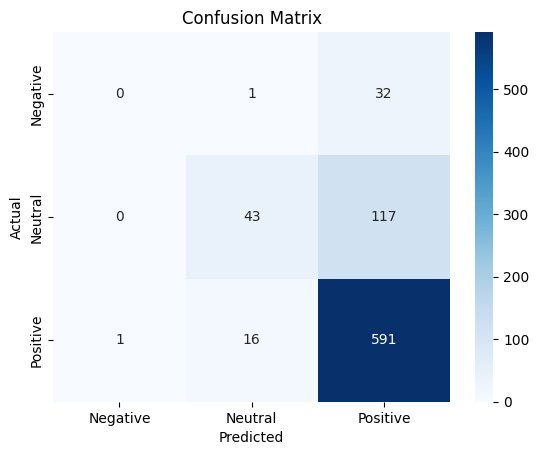

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [56]:
import pickle

# Save the model and vectorizer
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Load and reuse the model
with open('naive_bayes_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

In [67]:
# Predict using the loaded model
sample_text = ["Stocks hit an all-time high after quarterly results."]
sample_tfidf = loaded_vectorizer.transform(sample_text)
prediction = loaded_model.predict(sample_tfidf)
if prediction[0] == 0:
    print("negative")
elif prediction[0] == 1:
    print("positive")
else:
    print('netural')

print(prediction[0])


netural
2


In [22]:
df['Label'].unique()

array(['0', '1'], dtype=object)

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       623
     Neutral       0.89      0.95      0.92       581
    Positive       0.94      0.89      0.92       605

    accuracy                           0.95      1809
   macro avg       0.95      0.95      0.95      1809
weighted avg       0.95      0.95      0.95      1809



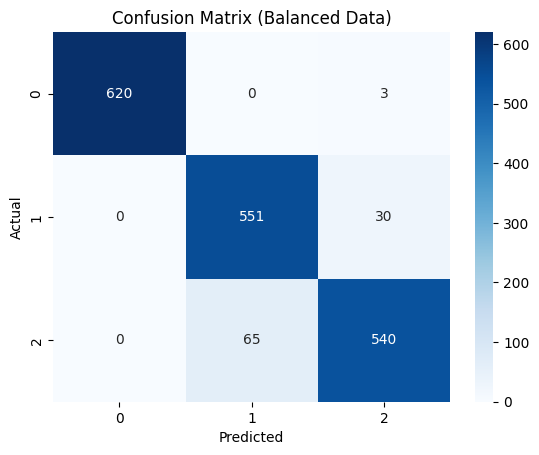

In [89]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Define the target classes
class_labels = [0, 1, 2]  # Negative, Neutral, Positive

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(vectorizer.fit_transform(df['Cleaned_Text']), df['Label'])

# Split the balanced data into training and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train a model (Random Forest as an example here)
model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_balanced = model.predict(X_test_balanced)

# Classification report and confusion matrix
print(classification_report(y_test_balanced, y_pred_balanced, target_names=['Negative', 'Neutral', 'Positive']))

conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced, labels=class_labels)
sns.heatmap(conf_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Balanced Data)')
plt.show()


c:\Users\HTW1KOR\.conda\envs\learning\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98       623
     Neutral       0.83      0.94      0.88       581
    Positive       0.93      0.78      0.85       605

    accuracy                           0.91      1809
   macro avg       0.91      0.91      0.90      1809
weighted avg       0.91      0.91      0.90      1809



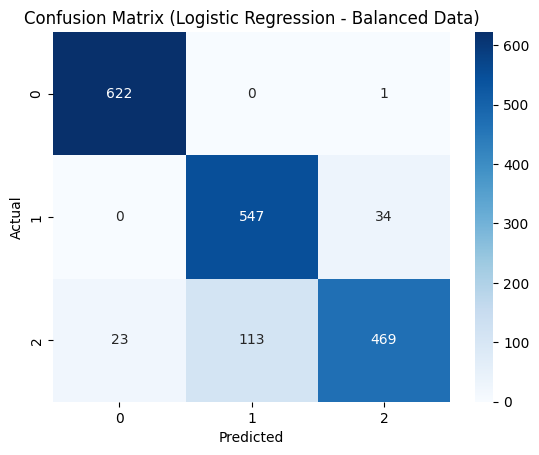

In [90]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model with balanced classes
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred_balanced_lr = model.predict(X_test_balanced)

# Classification report and confusion matrix
print(classification_report(y_test_balanced, y_pred_balanced_lr, target_names=['Negative', 'Neutral', 'Positive']))

conf_matrix_lr_balanced = confusion_matrix(y_test_balanced, y_pred_balanced_lr, labels=class_labels)
sns.heatmap(conf_matrix_lr_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression - Balanced Data)')
plt.show()


In [91]:
import pickle

# Save the model
with open('balanced_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('tfidf_vectorizer_balanced.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [92]:
import pickle
import numpy as np

# Load the model and vectorizer
with open('balanced_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('tfidf_vectorizer_balanced.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

# Define sample sentences for testing
sample_texts = [
    "The stock market is experiencing significant gains today.",
    "There are concerns about the economic slowdown.",
    "The product has received mixed reviews from customers.",
    "Despite challenges, the company reported record profits.",
    "The team's performance was disappointing in the last match."
]

# Predict and display sentiment for each sample
print("\nTesting Sentiments:")
for text in sample_texts:
    # Transform the text using the loaded vectorizer
    sample_tfidf = loaded_vectorizer.transform([text])
    
    # Predict the sentiment
    prediction = loaded_model.predict(sample_tfidf)
    predicted_label = class_labels[prediction[0]]
    
    # Output the result
    print(f"Text: '{text}'")
    print(f"Predicted Sentiment: {predicted_label}\n")



Testing Sentiments:
Text: 'The stock market is experiencing significant gains today.'
Predicted Sentiment: 1

Text: 'There are concerns about the economic slowdown.'
Predicted Sentiment: 1

Text: 'The product has received mixed reviews from customers.'
Predicted Sentiment: 2

Text: 'Despite challenges, the company reported record profits.'
Predicted Sentiment: 2

Text: 'The team's performance was disappointing in the last match.'
Predicted Sentiment: 0



In [93]:
# 0 -    negative
# 1 -   positive 
# 2 -    neutral